# Plotting binned glider cross-sections

_Written by Lori Garzio, June 23, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to generate a contour plot of 1m depth binned and 1km distance binned glider temperature. Depth will be on the y-axis and distance from shore will be on the x-axis. In this example we will be using data files that I have manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html) and manipulated. I [calculated mixed layer depth](https://github.com/lgarzio/noaa-oap/blob/master/glider_analyses/calculate_mld.py), [selected one cross-shelf transect and calculated distance from shore after manually selecting shoreline coordinates](https://github.com/lgarzio/noaa-oap/blob/master/glider_analyses/subset_ds.py). The files containing a single cross-shelf transect and additional variables can be found [here](https://marine.rutgers.edu/~lgarzio/phglider/WCR_analysis/files/).

On our contour plot we will also add a line plot for mixed layer depth and highlight the cold pool (where temperatures are <10 degrees C).

In [1]:
# import required packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cmo
plt.rcParams.update({'font.size': 12})  # all font sizes for the plot will be 12 unless otherwise specified

Specify where you want the plot to be saved on your local machine, and the file path for the dataset you would like to plot. Load the dataset using xarray and look at it for variables, time range, etc.

In [2]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'
f = '/Users/garzio/Documents/rucool/gliderdata/ru30-20210716T1804-delayed-transect.nc'
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:                         (time: 656344)
Coordinates:
  * time                            (time) datetime64[ns] 2021-07-16T18:06:48...
Data variables: (12/30)
    latitude                        (time) float64 ...
    longitude                       (time) float64 ...
    depth                           (time) float32 ...
    aragonite_saturation_state      (time) float32 ...
    chlorophyll_a                   (time) float32 ...
    conductivity                    (time) float32 ...
    ...                              ...
    temperature_interpolated        (time) float32 ...
    temperature_lag_shifted         (time) float32 ...
    total_alkalinity                (time) float32 ...
    mld                             (time) float64 ...
    mld_dbar                        (time) float64 ...
    dist_from_shore_km              (time) float64 ...
Attributes: (12/59)
    acknowledgment:                This deployment supported by the NOAA Ocea...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operated by the Rutgers University ...
    contributor_name:              Grace Saba, Theodore Thompson, Dave Aragon...
    ...                            ...
    subsetVariables:               wmo_id,trajectory,profile_id,time,latitude...
    summary:                       This project is conducting seasonal deploy...
    time_coverage_end:             2021-08-20T16:56:16.31Z
    time_coverage_start:           2021-07-16T18:06:48.11Z
    title:                         ru30-20210716T1804-delayed
    Westernmost_Easting:           -74.59385

Get the deployment name from the global attributes from the file. This is always good to have for file naming and adding titles to plots.

In [3]:
deployment_id = ds.title
deployment_id

'ru30-20210716T1804-delayed'

Next, print the temperature variable. The attributes will give you some important information about the variable, such as units.

In [4]:
ds.temperature

<xarray.DataArray 'temperature' (time: 656344)>
[656344 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-07-16T18:06:48.116182784 ... 2021-07-...
Attributes: (12/13)
    _ChunkSizes:       198
    actual_range:      [ 8.375  26.2883]
    colorBarMaximum:   32.0
    colorBarMinimum:   0.0
    comment:           Suspect/failed IOOS QC values, and values flagged by a...
    instrument:        instrument_ctd
    ...                ...
    long_name:         Sea Water Temperature
    observation_type:  measured
    standard_name:     sea_water_temperature
    units:             Celsius
    valid_max:         40.0
    valid_min:         -5.0

The dataset right now is structured as a time series, so we will need to group the data by profile and bin the data in 1m depth bins and 1km distance from shore bins.

In [5]:
# grab the maximum depth for the entire transect and round it up. this is for binning each profile 
# by 1m depth bins
depth_max = np.ceil(np.nanmax(ds.depth.values))
print(f'depth_max = {depth_max}')

# initialize empty arrays for distance from shore and MLD for each profile for plotting
profile_dist_from_shore = np.array([])
profile_mld_meters = np.array([])

# initialize empty list for the temperature data
data = []

depth_max = 109.0


Convert the dataset to a dataframe and drop all columns except depth, temperature, mixed layer depth, and distance from shore. Make sure you take depth_interpolated, if available in the dataset. If depth_interpolated isn't available, use depth instead.

In [6]:
df = ds.to_dataframe()
df = df[['depth_interpolated', 'temperature', 'mld', 'dist_from_shore_km']]
df

,depth_interpolated,temperature,mld,dist_from_shore_km
time,,,,
2021-07-16 18:06:48.116182784,5.448152,24.616501,NaN,8.734242
2021-07-16 18:06:48.116182784,5.964180,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,6.480208,23.378201,NaN,8.734242
2021-07-16 18:06:48.116182784,6.605906,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,6.731606,NaN,NaN,8.734242
...,...,...,...,...
2021-07-23 23:58:35.799094272,104.263329,NaN,NaN,130.012493
2021-07-23 23:58:35.799094272,104.296394,NaN,NaN,130.012493
2021-07-23 23:58:35.799094272,104.329460,13.926700,NaN,130.012493


Now, we'll group the data by time because, in these datasets, the "time" variable is unique to each profile. Note that if you're using a different dataset from a different source, time might not be unique to the profile and you might need to find a profile_time or profile_id variable. To illustrate the next step, I'll grab the first "group" (which is the first profile) and bin the data into 1m depth bins (from 0 to depth_max that we calculated for the entire transect).

In [7]:
grouped = df.groupby('time')
grouped

This groupby function returns a DataFrameGroupBy object. To look at the groups internally you have to iterate through each group, but first we'll just access the first group by using get_group(). From the dataframe above we know the first group timestamp is 2021-07-16 18:06:48.116182784 so we will use that (the group name since the dataframe was grouped by time) to grab that first profile.

In [8]:
profile1 = grouped.get_group('2021-07-16 18:06:48.116182784')
profile1

,depth_interpolated,temperature,mld,dist_from_shore_km
time,,,,
2021-07-16 18:06:48.116182784,5.448152,24.616501,NaN,8.734242
2021-07-16 18:06:48.116182784,5.964180,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,6.480208,23.378201,NaN,8.734242
2021-07-16 18:06:48.116182784,6.605906,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,6.731606,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,6.857304,23.435900,NaN,8.734242
2021-07-16 18:06:48.116182784,7.174858,22.791599,NaN,8.734242
2021-07-16 18:06:48.116182784,7.303864,NaN,NaN,8.734242
2021-07-16 18:06:48.116182784,7.432870,NaN,NaN,8.734242


There's the first profile in this dataset. The glider collected data from about 5m - 13m, there is no mixed layer depth for this profile (likely because the profile is too shallow), and the glider was about 9km from shore during this profile. Let's bin this dataset into 1m depth bins from the surface to the max depth for the entire transect.

In [9]:
bins = np.arange(0, depth_max+1, 1)  # Generate array of depths from 0 to depth_max at 1m increments
cut = pd.cut(profile1['depth_interpolated'], bins)  # Cut/Bin the dataframe based on the bins variable we just generated
binned_df = profile1.groupby(cut).mean()  # Groupby the cut and generate the average temperature for each bin
binned_df

,depth_interpolated,temperature,mld,dist_from_shore_km
depth_interpolated,,,,
"(0.0, 1.0]",NaN,NaN,NaN,NaN
"(1.0, 2.0]",NaN,NaN,NaN,NaN
"(2.0, 3.0]",NaN,NaN,NaN,NaN
"(3.0, 4.0]",NaN,NaN,NaN,NaN
"(4.0, 5.0]",NaN,NaN,NaN,NaN
...,...,...,...,...
"(104.0, 105.0]",NaN,NaN,NaN,NaN
"(105.0, 106.0]",NaN,NaN,NaN,NaN
"(106.0, 107.0]",NaN,NaN,NaN,NaN


There is the 1m depth averaged dataframe for this profile. The majority of the values are NaN because the glider only collected data between 5-13m. So if we look at the top 15 rows in the dataframe we'll see the binned data for the profile. We need all of the placeholders for the entire depth range so we can generate a contour plot at the end.

In [10]:
binned_df.head(15)

,depth_interpolated,temperature,mld,dist_from_shore_km
depth_interpolated,,,,
"(0.0, 1.0]",NaN,NaN,NaN,NaN
"(1.0, 2.0]",NaN,NaN,NaN,NaN
"(2.0, 3.0]",NaN,NaN,NaN,NaN
"(3.0, 4.0]",NaN,NaN,NaN,NaN
"(4.0, 5.0]",NaN,NaN,NaN,NaN
"(5.0, 6.0]",5.706166,24.616501,NaN,8.734242
"(6.0, 7.0]",6.668756,23.407051,NaN,8.734242
"(7.0, 8.0]",7.542029,22.145632,NaN,8.734242
"(8.0, 9.0]",8.568121,20.716150,NaN,8.734242


Ok, now that we've seen what the code does, let's put everything together and calculate the depth-binned averages for every profile in this transect. We'll append all of the data we need for plotting to the empty arrays we made in the beginning. Once we've manipulated all of the profiles for this dataset we can move on to binning by distance from shore and then finally plotting the transect. This block of code will take a few seconds since it's looping through each profile.

In [11]:
for group in grouped:
    bins = np.arange(0, depth_max+1, 1)  # Generate array of depths from 0 to depth_max at 1m increments
    cut = pd.cut(group[1]['depth_interpolated'], bins)  # Cut/Bin the dataframe based on the bins variable we just generated
    binned_df = group[1].groupby(cut).mean()  # Groupby the cut and generate the average temperature for each bin
    
    # add profile distance from shore and MLD to the arrays that we will use for plotting
    profile_dist_from_shore = np.append(profile_dist_from_shore, np.nanmean(binned_df['dist_from_shore_km']))
    profile_mld_meters = np.append(profile_mld_meters, np.nanmean(binned_df['mld']))
    
    # add the binned temperature data to the list
    data.append(binned_df['temperature'].values.tolist())
    

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_42631/1926233736.py:8: RuntimeWarning: Mean of empty slice
  profile_mld_meters = np.append(profile_mld_meters, np.nanmean(binned_df['mld']))


In [12]:
# group MLD by distance from shore in 1km depth bins
df_mld = pd.DataFrame({'profile_mld_meters': profile_mld_meters})
df_mld['distance_from_shore'] = np.round(profile_dist_from_shore)
df_mld = df_mld.groupby('distance_from_shore').mean()
df_mld

,profile_mld_meters
distance_from_shore,
9.0,5.473425
10.0,4.595084
11.0,4.425263
12.0,3.718241
13.0,4.334278
...,...
127.0,10.070332
128.0,3.932813
129.0,5.217676


In [13]:
# group the temperature data by distance from shore in 1km depth bins
temperature_df = pd.DataFrame(data)
temperature_df['distance_from_shore'] = np.round(profile_dist_from_shore)
temperature_df = temperature_df.groupby('distance_from_shore').mean()
temperature_df = temperature_df.transpose()  # rows = depth, columns = distance from shore
temperature_df

distance_from_shore,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,...,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,130.0,131.0
0,24.729650,24.881435,24.907036,24.892804,24.800247,24.771949,24.748169,24.669480,24.634193,24.630583,...,NaN,NaN,24.491007,24.461468,23.989007,24.051001,NaN,24.458387,24.246205,24.221684
1,24.710691,24.854467,24.905521,24.876459,24.802790,24.773792,24.746326,24.662499,24.632602,24.629484,...,NaN,NaN,24.527267,24.513161,23.962871,24.068955,23.974020,24.276135,24.292435,24.178865
2,24.574905,24.799188,24.878804,24.851061,24.799809,24.772563,24.745424,24.659455,24.622304,24.614407,...,24.598246,24.525345,24.526674,24.510864,24.022825,23.949781,23.913851,24.233679,24.173618,24.040375
3,24.390037,24.634596,24.706217,24.371088,24.701888,24.747202,24.726837,24.617515,24.370923,24.407912,...,24.492507,24.469271,24.463467,24.461734,24.029769,23.907911,23.427621,24.007986,23.939717,23.877199
4,24.144681,23.906279,23.846537,23.082998,23.522062,24.056434,24.433083,23.894961,23.287345,23.299297,...,24.370989,24.418588,24.383986,24.389107,24.024004,23.763523,22.736578,23.564509,23.551614,23.721750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.074739,14.094483
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.092276,14.095750
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.093834,14.094317
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.094214,14.091619


In [14]:
# generate x and y 2-D arrays for the contour plot
x, y = np.meshgrid(temperature_df.columns.values, temperature_df.index.values)

Specify the title and levels for the colorbar and the color map. For this colormap we're using the [cmocean](https://matplotlib.org/cmocean/) "thermal" colormap. Check out the documentation for all of the other colormaps that could be useful for plotting additional glider data.

In [15]:
colorbar_title = 'Temperature (\N{DEGREE SIGN}C)'
colorbar_levels = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
cmap = cmo.cm.thermal

Now the we have the data in the format we need for generating the filled contour plot. We will highlight the cold pool in the plot by making a white contour line around temperatures of 10 degrees C. You can set the x- and y-limits if you want (this can be helpful when you're plotting multiple deployments and want to compare them). We also want to plot a horizontal line where the 10C isobath (cold pool) intersects with the bottom - in order to figure that out we're going to generate the plot and estimate the extent of the cold pool.

[Text(0, 0.5, 'Depth (m)'),
 Text(0.5, 0, 'Distance from Shore (km)'),
 Text(0.5, 1.0, 'ru30-20210716T1804-delayed')]

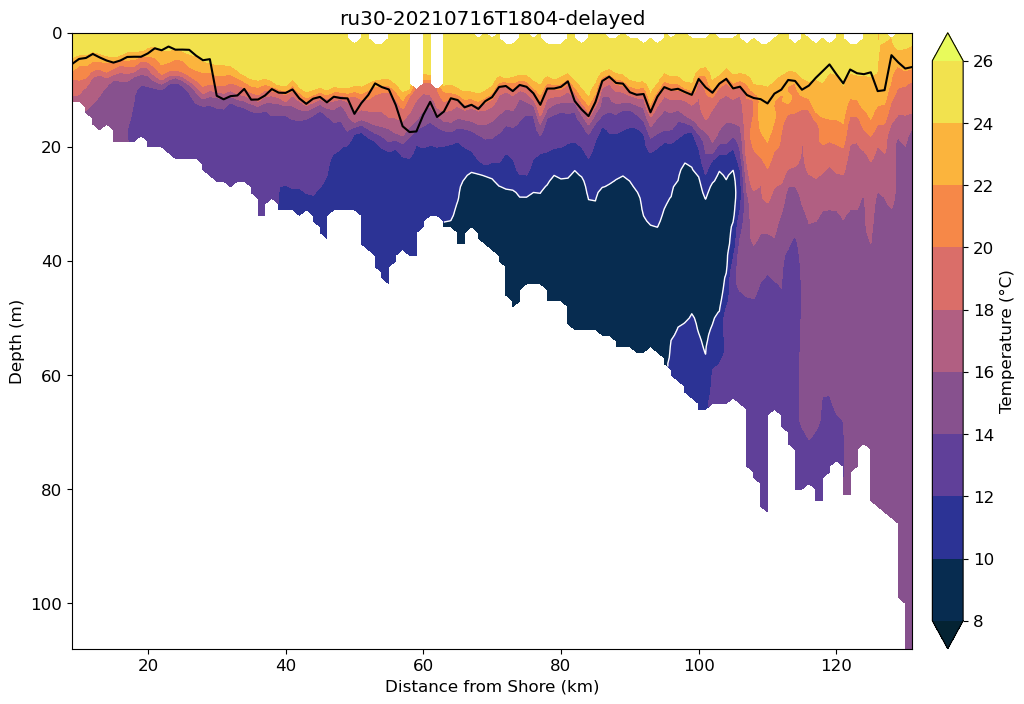

In [16]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.subplots_adjust(left=0.08, right=1)

cs = plt.contourf(x, y, temperature_df, levels=colorbar_levels, cmap=cmap, extend='both')
plt.colorbar(cs, ax=ax, label=colorbar_title, pad=0.02)

# ax.set_ylim([0, 200])  # set the y-limits
# ax.set_xlim([10, 200])  # set the x-limits

# plot the white contour line around 10 degrees C to highlight the coldpool
ax.contour(x, y, temperature_df, [10], colors='white', linewidths=1)

ax.invert_yaxis()

# add a line plot of the MLD
ax.plot(df_mld.index.values, df_mld.profile_mld_meters.values, ls='-', lw=1.5, color='k')

plt.setp(ax, ylabel='Depth (m)', xlabel='Distance from Shore (km)', title=deployment_id)  # add labels

In this plot, the black line indicates the Mixed Layer Depth, and the white line highlights the cold pool. It looks like the 10C isobath intersects with the bottom around 95km from shore. In order to add that horizontal line to the plot at the correct location, we need to figure out the depth associated with that point.

In [17]:
cp_extent = 95
cpdf = temperature_df[cp_extent].dropna()  # find the 95 km distance from shore bin in the temperature dataframe
cp_depth = np.nanmax(cpdf.index)  # find the max depth bin
print(f'cold pool extent = {cp_extent}km from shore')
print(f'cold pool depth = {cp_depth}m')

cold pool extent = 95km from shore
cold pool depth = 58m


Ok now that we have the cold pool extent and depth, let's add that line to the final plot!

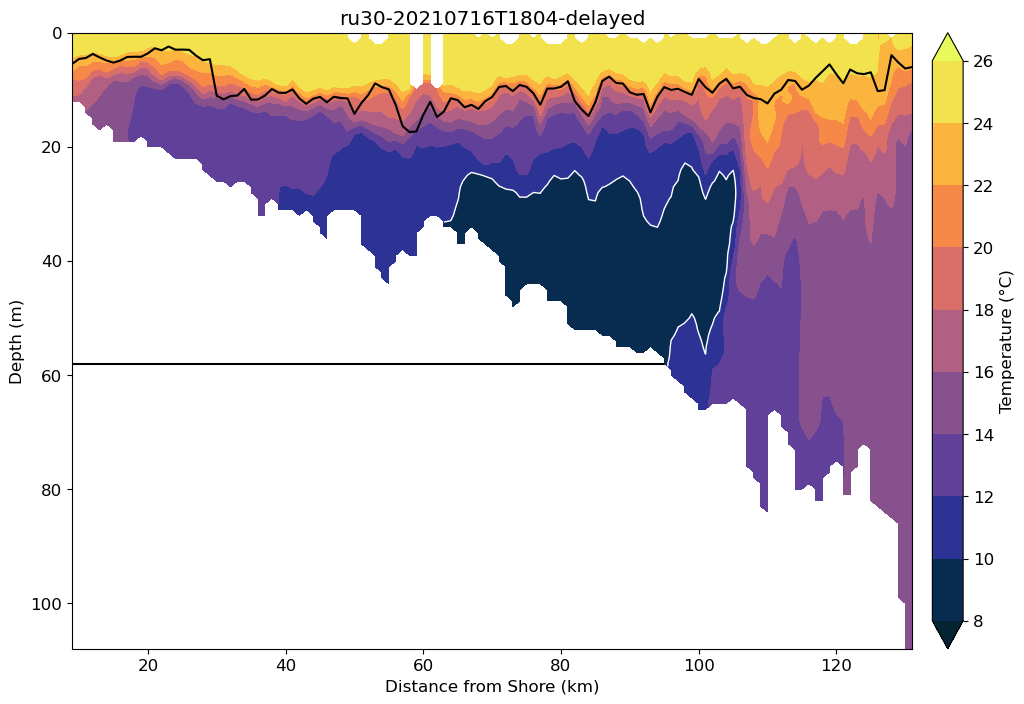

In [18]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.subplots_adjust(left=0.08, right=1)

cs = plt.contourf(x, y, temperature_df, levels=colorbar_levels, cmap=cmap, extend='both')
plt.colorbar(cs, ax=ax, label=colorbar_title, pad=0.02)

# ax.set_ylim([0, 200])  # set the y-limits
# ax.set_xlim([10, 200])  # set the x-limits

# plot the white contour line around 10 degrees C to highlight the coldpool
ax.contour(x, y, temperature_df, [10], colors='white', linewidths=1)

# plot a horizontal line where the 10C isobath intersects with the bottom
plot_xlims = ax.get_xlim()
ax.hlines(cp_depth, plot_xlims[0], cp_extent, colors='k')

ax.invert_yaxis()

# add a line plot of the MLD
ax.plot(df_mld.index.values, df_mld.profile_mld_meters.values, ls='-', lw=1.5, color='k')

plt.setp(ax, ylabel='Depth (m)', xlabel='Distance from Shore (km)', title=deployment_id)  # add labels

sfile = os.path.join(save_dir, f'{deployment_id}_temperature_xsection_transect.png')
plt.savefig(sfile, dpi=200)